In [ ]:
import os
import random
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense
from sklearn.metrics import roc_curve, auc, confusion_matrix
from statsmodels.stats.proportion import proportion_confint
from tensorflow.keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

np.random.seed(5)
tf.random.set_seed(5)
random.seed(5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Funciones**

#### **Separacion / Organizacion datos entrada**

In [ ]:
def separar_organizar_d_entrada(d_raiz, d_entrenamiento, d_validacion, rango_corte, t_datos_entrenamiento=0.8):
    try:
        # Listar todas las carpetas dentro del rango especificado
        for folder in os.listdir(d_raiz):
            if os.path.isdir(os.path.join(d_raiz, folder)) and rango_corte[0] <= folder <= rango_corte[1]:
                folder_path = os.path.join(d_raiz, folder)
                files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

                # Desordenar los archivos para una division aleatoria
                shuffle(files)

                # Calcular el indice de corte para la division entrenamiento-validacion
                split_index = int(len(files) * t_datos_entrenamiento)
                train_files = files[:split_index]
                validation_files = files[split_index:]

                # Crear directorios específicos de carpeta dentro de train y validation
                train_folder_path = os.path.join(d_entrenamiento, folder)
                validation_folder_path = os.path.join(d_validacion, folder)
                os.makedirs(train_folder_path, exist_ok=True)
                os.makedirs(validation_folder_path, exist_ok=True)

                # Mover archivos a los directorios de entrenamiento y validación
                for file in train_files:
                    shutil.move(os.path.join(folder_path, file), os.path.join(train_folder_path, file))

                for file in validation_files:
                    shutil.move(os.path.join(folder_path, file), os.path.join(validation_folder_path, file))

                # Eliminar la carpeta original si esta vacia
                if not os.listdir(folder_path):
                    os.rmdir(folder_path)

    except Exception as e:
        print(f"Error al organizar y dividir los datos: {e}")

#### **Modelos**

    Modelo con BatchNormalization = True

In [ ]:
def create_model_con_bn(learning_rate):
    model = Sequential([

        tf.keras.layers.Rescaling(scale=1./255, input_shape=(200, 200, 3)),

        Conv2D(32, (3, 3), activation='relu', padding='same'),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        BatchNormalization(),

        GlobalAveragePooling2D(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Recall(name='sensitivity'),
                           tf.keras.metrics.TruePositives(name='tp'),
                           tf.keras.metrics.TrueNegatives(name='tn'),
                           tf.keras.metrics.FalsePositives(name='fp'),
                           tf.keras.metrics.FalseNegatives(name='fn')])
    return model

    Modelo con BatchNormalization = False

In [ ]:
def create_model_sin_bn(learning_rate):
    model = Sequential([

        tf.keras.layers.Rescaling(scale=1./255, input_shape=(200, 200, 3)),

        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(200, 200, 3)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),

        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),

        GlobalAveragePooling2D(),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=[tf.keras.metrics.Recall(name='sensitivity'),
                           tf.keras.metrics.TruePositives(name='tp'),
                           tf.keras.metrics.TrueNegatives(name='tn'),
                           tf.keras.metrics.FalsePositives(name='fp'),
                           tf.keras.metrics.FalseNegatives(name='fn')])
    return model

#### **Graficas**

    Visualizar Train / Val de todos modelos

In [ ]:
def graficar_metricas(histories, metric):
    plt.figure(figsize=(18, 8))

    plt.subplot(1, 2, 1)
    for history, model_info in zip(histories, models):
        train_values = history.history[metric]
        epochs = range(1, len(train_values) + 1)
        final_value = train_values[-1]
        plt.plot(epochs, train_values, label=f'{model_info[1]} (final: {final_value:.2f})')

    plt.title('Entrenamiento', fontsize=16, fontweight='bold')
    plt.xlabel('Epocas')
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1)
    plt.xticks(range(1, len(epochs) + 1))
    plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
    plt.grid(True)

    plt.subplot(1, 2, 2)
    for history, model_info in zip(histories, models):
        val_values = history.history['val_' + metric]
        epochs = range(1, len(val_values) + 1)
        final_value = val_values[-1]
        plt.plot(epochs, val_values, '--', label=f'{model_info[1]} (final: {final_value:.2f})')

    plt.title('Validacion', fontsize=16, fontweight='bold')
    plt.xlabel('Epocas')
    plt.ylabel(metric.capitalize())
    plt.ylim(0, 1)
    plt.xticks(range(1, len(epochs) + 1))
    plt.legend(loc='upper left', bbox_to_anchor=(0, 1))
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    Curva ROC

In [ ]:
def plot_roc_curve(ax, y_true, y_scores, model_info):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive')
    ax.set_ylabel('True Positive')
    ax.set_title(f'Curva ROC', fontsize=10)
    ax.legend(loc='lower right')

    Sensibilidad Train / Validacion

In [ ]:
def plot_sensitivity(ax, history):
    sensitivity_train = np.array(history.history['tp']) / (np.array(history.history['tp']) + np.array(history.history['fn']))
    sensitivity_val = np.array(history.history['val_tp']) / (np.array(history.history['val_tp']) + np.array(history.history['val_fn']))
    epochs = range(1, len(sensitivity_train) + 1)
    final_sensitivity_train = sensitivity_train[-1]
    final_sensitivity_val = sensitivity_val[-1]
    ax.plot(epochs, sensitivity_train, label=f'Sensibilidad Train {final_sensitivity_train:.2f}')
    ax.plot(epochs, sensitivity_val, '--', label=f'Sensibilidad Val {final_sensitivity_val:.2f}')
    ax.set_xlabel('Epocas')
    ax.set_ylabel('Valor')
    ax.set_title(f'Sensibilidad', fontsize=10)
    ax.legend(loc='lower right')
    ax.set_ylim(0, 1)
    ax.set_xticks(range(1, len(epochs) + 1))

    Specificidad Train / Validacion

In [ ]:
def plot_specificity(ax, history):
    specificity_train = np.array(history.history['tn']) / (np.array(history.history['tn']) + np.array(history.history['fp']))
    specificity_val = np.array(history.history['val_tn']) / (np.array(history.history['val_tn']) + np.array(history.history['val_fp']))
    epochs = range(1, len(specificity_train) + 1)
    final_specificity_train = specificity_train[-1]
    final_specificity_val = specificity_val[-1]
    ax.plot(epochs, specificity_train, label=f'Especificidad Train {final_specificity_train:.2f}')
    ax.plot(epochs, specificity_val, '--', label=f'Especificidad Val {final_specificity_val:.2f}')
    ax.set_xlabel('Epocas')
    ax.set_ylabel('Valor')
    ax.set_title(f'Especificidad', fontsize=10)
    ax.legend(loc='lower right')
    ax.set_ylim(0, 1)
    ax.set_xticks(range(1, len(epochs) + 1))

    Matriz confusion

In [ ]:
def plot_confusion_matrix(ax, y_true, y_pred, model_info):
    cm = confusion_matrix(y_true, y_pred)
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]

    # colores
    success_color = mcolors.to_rgb('#9EE548')
    failure_color = mcolors.to_rgb("#C32240")
    ax.imshow([[success_color, failure_color], [failure_color, success_color]])

    labels = ['Positivo', 'Negativo']
    xaxis = np.arange(len(labels))
    ax.set_xticks(xaxis)
    ax.set_yticks(xaxis)
    ax.set_xticklabels(labels, fontsize=13, color="#003B80")
    ax.set_yticklabels(labels, fontsize=13, color="#003B80")
    ax.text(0, 0, str(tp) + " TP", ha="center", va="center", color="#0A2102", fontsize=15)
    ax.text(0, 1, str(fp) + " FP", ha="center", va="center", color="#FAEAEA", fontsize=15)
    ax.text(1, 0, str(fn) + " FN", ha="center", va="center", color="#FAEAEA", fontsize=15)
    ax.text(1, 1, str(tn) + " TN", ha="center", va="center", color="#0A2102", fontsize=15)
    ax.xaxis.tick_top()
    ax.set_xlabel('Prediccion', fontsize=15, color="#003B80")
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Realidad', fontsize=15, color="#003B80")
    # ax.set_title(f'Matriz Confusion: {model_info}', fontsize=15)
    plt.tight_layout()

    Mostrar Curva ROC / esp,sens / Matriz en un mismo plot

In [ ]:
def plot_all_metrics(histories, y_trues, y_scores, y_preds, models):
    n_models = len(models)
    fig, axes = plt.subplots(n_models, 4, figsize=(24, 6 * n_models))

    for i, (history, y_true, y_score, y_pred, model_info) in enumerate(zip(histories, y_trues, y_scores, y_preds, models)):
        # Agregar el título del modelo a la izquierda de la fila
        fig.text(0.04, 1 - (i + 0.5) / n_models, model_info[1], va='center', ha='center', rotation='vertical', fontsize=16, fontweight='bold')
        # Curva ROC
        plot_roc_curve(axes[i, 0], y_true, y_score, model_info[1])
        # Especificidad para entrenamiento y validación
        plot_specificity(axes[i, 1], history)
        # Sensibilidad para entrenamiento y validación
        plot_sensitivity(axes[i, 2], history)
        # Matriz de Confusión
        plot_confusion_matrix(axes[i, 3], y_true, y_pred, model_info[1])

    plt.tight_layout(rect=[0.1, 0, 1, 1])
    plt.show()

    Obtener Sensibilidad / Especificidad para grafica

In [ ]:
def plot_sens_spec(ax, y_true, y_scores):
    thresholds = np.linspace(0, 1, 1000)
    sensitivities = []
    specificities = []

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        sensitivities.append(sensitivity)
        specificities.append(specificity)

    best_threshold_idx = np.argmax(np.array(sensitivities) + np.array(specificities))
    best_threshold = thresholds[best_threshold_idx]
    best_sensitivity = sensitivities[best_threshold_idx]
    best_specificity = specificities[best_threshold_idx]

    ax.plot(thresholds, sensitivities, label="Sensibilidad", color="blue")
    ax.plot(thresholds, specificities, label="Especificidad", color="orange")

    # Línea vertical para el mejor threshold
    ax.axvline(x=best_threshold, color='red', linestyle='--')

    ax.text(best_threshold, 0.5, f'{best_threshold:.3f}', color='red', fontsize=12, ha='center')

    ax.set_xlabel('Threshold')
    ax.set_ylabel('Metricas')
    ax.legend()
    ax.grid(True)
    ax.legend(loc='lower right')

    return best_sensitivity, best_specificity, best_threshold

    Metricas con threshold

In [ ]:
def calculate_metrics_at_best_threshold(y_true, y_scores):
    thresholds = np.linspace(0, 1, 1000)
    best_threshold = 0.5
    best_sensitivity = 0
    best_specificity = 0

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        if sensitivity + specificity > best_sensitivity + best_specificity:
            best_threshold = threshold
            best_sensitivity = sensitivity
            best_specificity = specificity

    return best_sensitivity, best_sensitivity, best_threshold

    Intervalo confianza con Jeffrey

In [ ]:
def calculate_metrics_with_intervals(y_true, y_score, confidence_level=0.95):
    thresholds = np.linspace(0, 1, 1000)
    best_threshold = 0.5
    best_sensitivity = 0
    best_specificity = 0
    best_cm = None

    for threshold in thresholds:
        y_pred = (y_score >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        if sensitivity + specificity > best_sensitivity + best_specificity:
            best_threshold = threshold
            best_sensitivity = sensitivity
            best_specificity = specificity
            best_cm = cm

    # calcular intervalos de confianza con Jeffreys
    if best_cm is not None:
        tn, fp, fn, tp = best_cm.ravel()
        lower_sens, upper_sens = proportion_confint(tp, tp + fn, method="jeffreys", alpha=1 - confidence_level)
        lower_spec, upper_spec = proportion_confint(tn, tn + fp, method="jeffreys", alpha=1 - confidence_level)

        sens_interval = (lower_sens, upper_sens)
        spec_interval = (lower_spec, upper_spec)
    else:
        sens_interval = (0, 0)
        spec_interval = (0, 0)

    return best_sensitivity, best_specificity, best_threshold, sens_interval, spec_interval

    Graficar intervalos confianza

In [ ]:
def plot_confidence_intervals(ax, models, sensitivities, specificities, sens_intervals, spec_intervals):
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

    for i, (sensitivity, specificity, sens_int, spec_int) in enumerate(zip(sensitivities, specificities, sens_intervals, spec_intervals)):
        color = colors[i % len(colors)]
        sens_lower, sens_upper = sens_int
        spec_lower, spec_upper = spec_int

        # corregir valores negativos
        sens_lower = max(sens_lower, 0)
        sens_upper = max(sens_upper, 0)
        sensitivity = max(sensitivity, 0)
        spec_lower = max(spec_lower, 0)
        spec_upper = max(spec_upper, 0)
        specificity = max(specificity, 0)

        sens_xerr = [[sensitivity - sens_lower], [sens_upper - sensitivity]]
        spec_xerr = [[specificity - spec_lower], [spec_upper - specificity]]

        if sensitivity - sens_lower < 0 or sens_upper - sensitivity < 0:
            sens_xerr = [[0], [0]]
        if specificity - spec_lower < 0 or spec_upper - specificity < 0:
            spec_xerr = [[0], [0]]

        ax.errorbar(sensitivity, i, xerr=sens_xerr, fmt='^', label=f'{models[i][1]} Sensibilidad [{sens_lower:.2f}, {sens_upper:.2f}]', color=color)
        ax.errorbar(specificity, i, xerr=spec_xerr, fmt='o', label=f'{models[i][1]} Especificidad [{spec_lower:.2f}, {spec_upper:.2f}]', color=color)

    ax.set_title('Sensibilidad y Especificidad con intervalos de confianza')
    ax.set_xlabel('Metrica')
    ax.set_yticks(range(len(models)))
    ax.set_yticklabels([model[1] for model in models])
    ax.invert_yaxis()
    ax.grid(True)
    ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)

    Mostrar las dos funciones previas juntas

In [ ]:
def plot_metrics_and_intervals(histories, y_trues, y_scores, models):
    sensitivities = []
    specificities = []
    sens_intervals = []
    spec_intervals = []

    for i, (y_true, y_score, model_info) in enumerate(zip(y_trues, y_scores, models)):
        best_sensitivity, best_specificity, best_threshold, sens_interval, spec_interval = calculate_metrics_with_intervals(y_true, y_score)
        sensitivities.append(best_sensitivity)
        specificities.append(best_specificity)
        sens_intervals.append(sens_interval)
        spec_intervals.append(spec_interval)
        histories[i].history['val_sensitivity'] = [best_sensitivity]
        histories[i].history['val_specificity'] = [best_specificity]

    fig, ax = plt.subplots(figsize=(15, 10))
    plot_confidence_intervals(ax, models, sensitivities, specificities, sens_intervals, spec_intervals)
    plt.tight_layout(pad=5.0)
    plt.show()

## **1. Separar Imagenes en Train/Test**

In [ ]:
d_raiz = '/content/drive/MyDrive/DATA'

# Directorios para datos de entrenamiento y validación
train_menores = '/content/drive/MyDrive/DATA/train/menores_18'
validation_menores = '/content/drive/MyDrive/DATA/validation/menores_18'
train_mayores = '/content/drive/MyDrive/DATA/train/mayores_18'
validation_mayores = '/content/drive/MyDrive/DATA/validation/mayores_18'

# Menores de 18
separar_organizar_d_entrada(d_raiz, train_menores, validation_menores, ('001', '017'))

# Mayores de 18
separar_organizar_d_entrada(d_raiz, train_mayores, validation_mayores, ('018', '110'))

print("Proceso de organización y división de archivos completado.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/DATA/061/524.png'

## **2. Preparacion de los datos**

In [ ]:
train_dir = '/content/drive/MyDrive/DATA/train'
validation_dir = '/content/drive/MyDrive/DATA/validation'

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(200, 200),
    batch_size=32,
    label_mode='binary',
    shuffle=True)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(200, 200),
    batch_size=32,
    label_mode='binary',
    shuffle=False)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Found 7785 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


    Visualizar dataset de entrenamiento

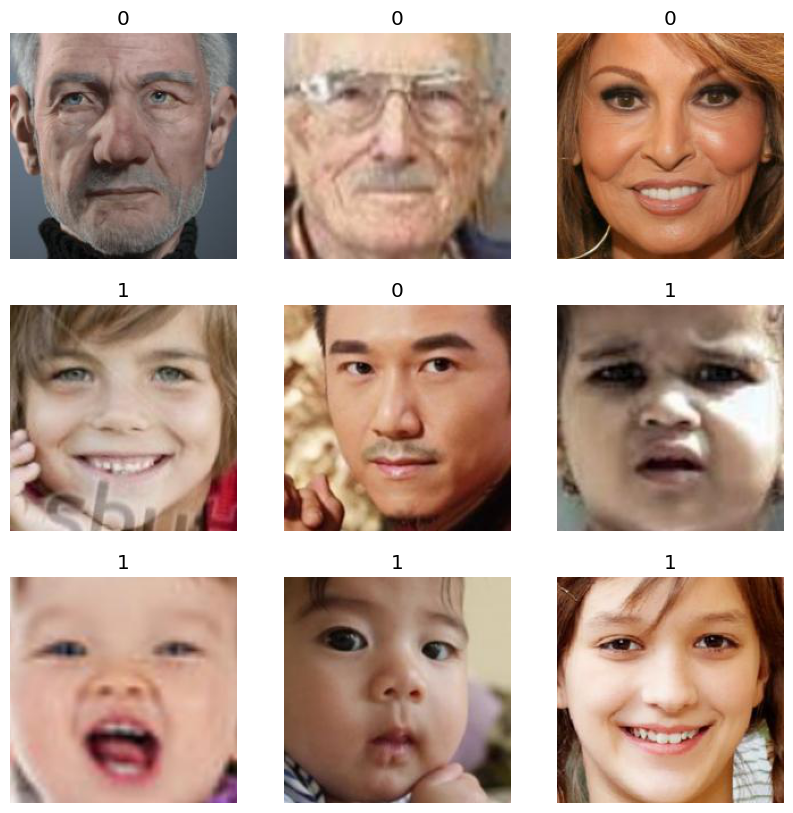

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    if labels[i] == 0:
        plt.title('0')
    elif labels[i] == 1:
        plt.title('1')
    plt.axis("off")

    Visualizar dataset de validacion

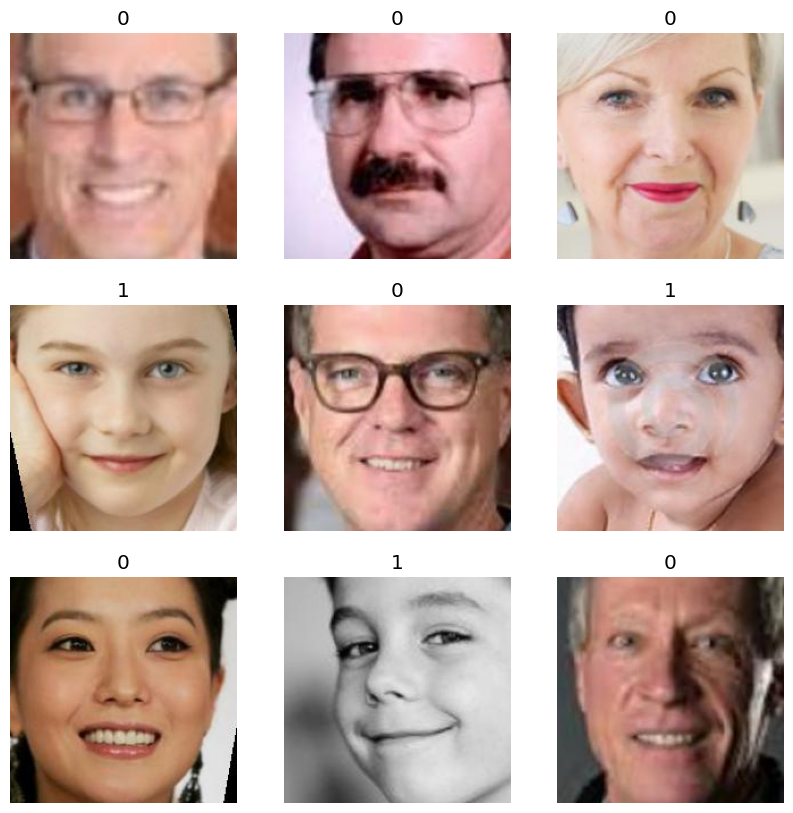

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in validation_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    if labels[i] == 0:
        plt.title('0')
    elif labels[i] == 1:
        plt.title('1')
    plt.axis("off")

### **Temp para tomas**

## **3. Entrenamiento del modelo**

In [ ]:
learning_rates = [0.01, 0.001, 0.0001, 0.00001]
batch_sizes = [32, 64]
use_batch_norm_options = [True, False]

models = []
histories = []

for batch_size in batch_sizes:
    for lr in learning_rates:
        for use_bn in use_batch_norm_options:
            if use_bn == True:
                print("---")
                model = create_model_con_bn(lr)
                history = model.fit(
                    train_dataset,
                    validation_data=validation_dataset,
                    epochs=5,
                    batch_size=batch_size)
                models.append((model, f"LR={lr}, BS={batch_size}, BN={use_bn}"))
                histories.append(history)
            if use_bn == False:
                print("---")
                model = create_model_sin_bn(lr)
                history = model.fit(
                    train_dataset,
                    validation_data=validation_dataset,
                    epochs=5,
                    batch_size=batch_size)
                models.append((model, f"LR={lr}, BS={batch_size}, BN={use_bn}"))
                histories.append(history)

---
Epoch 1/5
244/244 [==============================] - 1176s 5s/step - loss: 0.6378 - sensitivity: 0.4346 - tp: 1362.0000 - tn: 3807.0000 - fp: 844.0000 - fn: 1772.0000 - val_loss: 0.6024 - val_sensitivity: 0.4172 - val_tp: 330.0000 - val_tn: 1026.0000 - val_fp: 183.0000 - val_fn: 461.0000
Epoch 2/5
244/244 [==============================] - 18s 72ms/step - loss: 0.5131 - sensitivity: 0.5849 - tp: 1833.0000 - tn: 4015.0000 - fp: 636.0000 - fn: 1301.0000 - val_loss: 0.6520 - val_sensitivity: 0.5310 - val_tp: 420.0000 - val_tn: 966.0000 - val_fp: 243.0000 - val_fn: 371.0000
Epoch 3/5
244/244 [==============================] - 18s 73ms/step - loss: 0.3905 - sensitivity: 0.7198 - tp: 2256.0000 - tn: 4224.0000 - fp: 427.0000 - fn: 878.0000 - val_loss: 0.7102 - val_sensitivity: 0.9191 - val_tp: 727.0000 - val_tn: 502.0000 - val_fp: 707.0000 - val_fn: 64.0000
Epoch 4/5
244/244 [==============================] - 18s 73ms/step - loss: 0.3148 - sensitivity: 0.7786 - tp: 2440.0000 - tn: 4306.00

## **4. Realizar graficas**

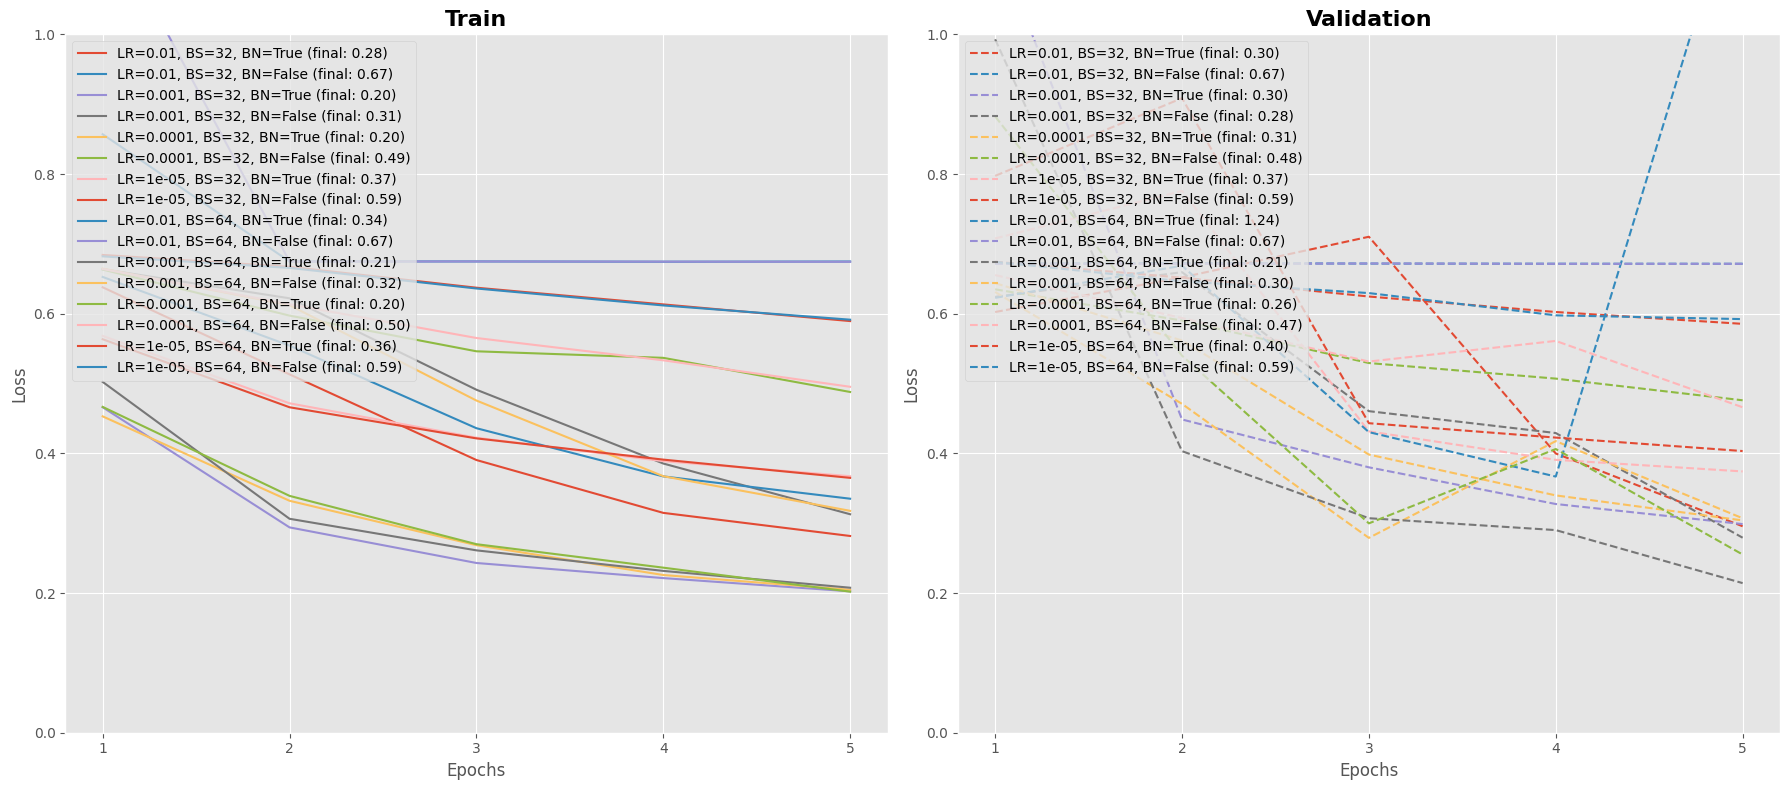

In [ ]:
graficar_metricas(histories, 'loss')

---

Esta grafica muestra la perdida de entrenamiento y validacion en función de la epoca. Los modelos con **LR=0.001, BS=64, BN=Tru** y **LR=0.0001, BS=64, BN=True** **tienen la menor perdida de validacion** en comparacion con los otros modelos, lo que indica que tienen una **buena capacidad de aprendizaje**.

---

In [ ]:
y_trues = []
y_scores = []
y_preds = []
for model, _ in models:
    y_true = np.concatenate([y for x, y in validation_dataset], axis=0)
    y_score = model.predict(validation_dataset);
    y_pred = (y_score > 0.5).astype(int)

    y_trues.append(y_true)
    y_scores.append(y_score)
    y_preds.append(y_pred)

63/63 [==============================] - 2s 36ms/step


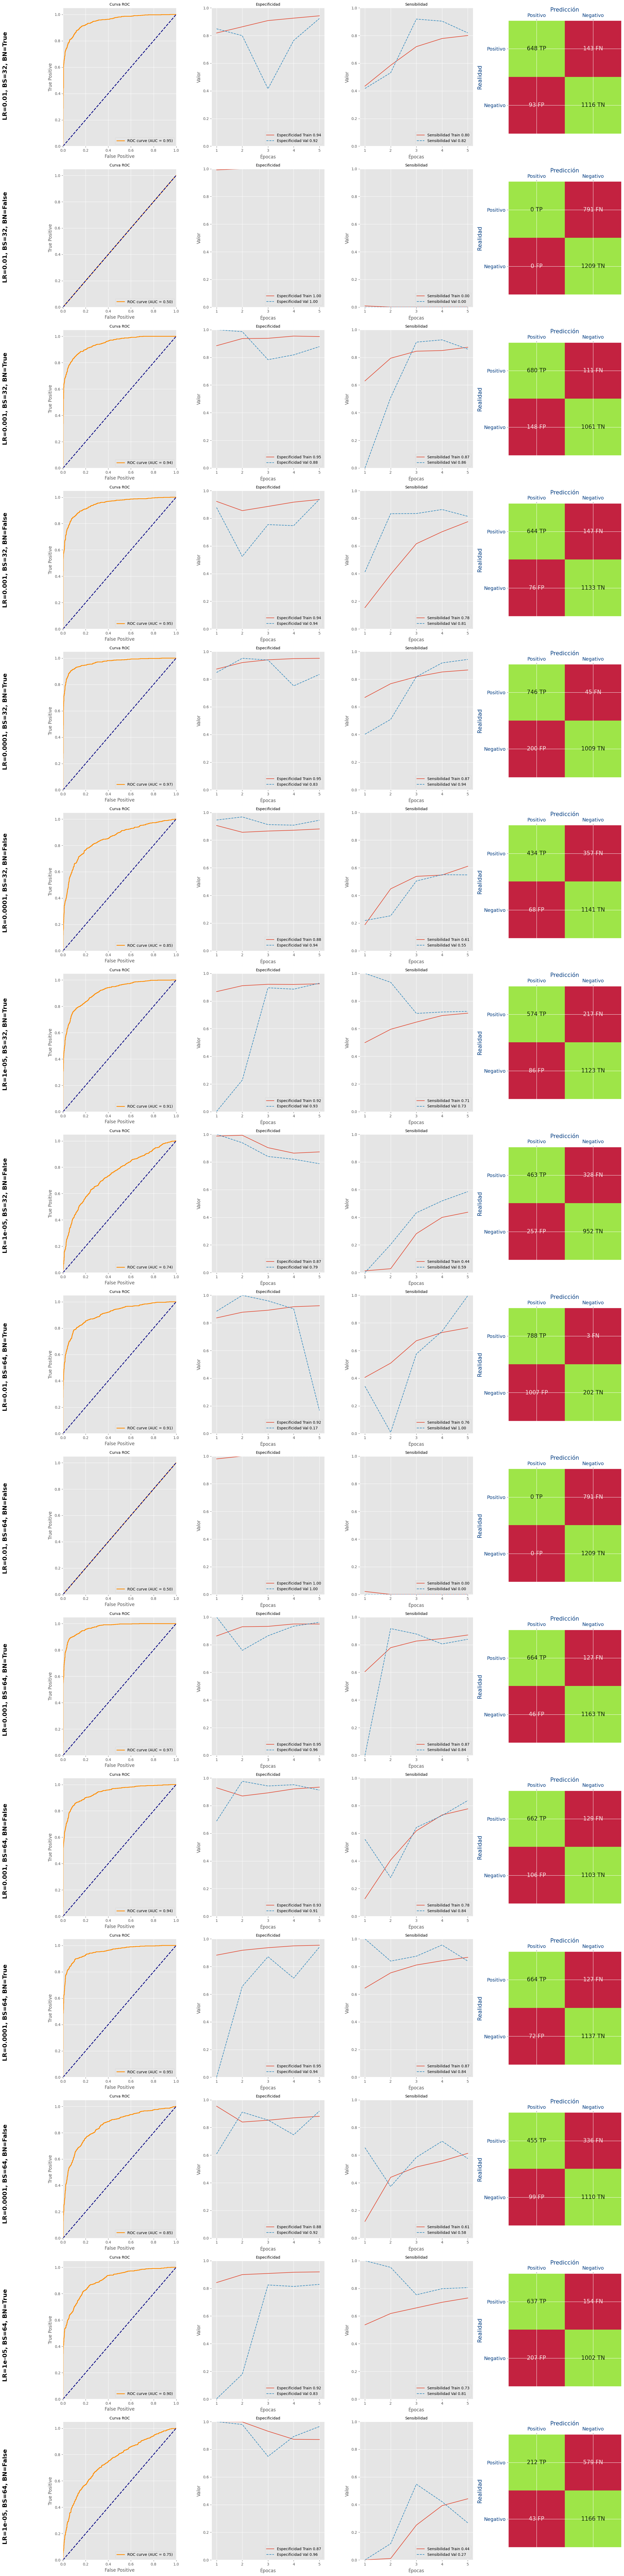

In [ ]:
plot_all_metrics(histories, y_trues, y_scores, y_preds, models)

---

En estas graficas se observa que la **sensibilidad y especificidad en entrenamiento y validacion varian de una manera bastante considerable entre los modelos**. Los modelos con **BN=True tienden a mantener una sensibilidad alta a lo largo de las epocas**, lo cual es una parte muy importante para el objetivo de nuestro modelo, para detectar menores de edad. La especificidad es mas alta en algunos modelos con BN=False, pero esto no es tan critico para nuestro caso de uso.

Tambien se puede observar que existen modelos (2 exactamente) que por alguna razon obtienen unas metricas muy raras, lo que tienen en comun es la baja tasa de aprendizaje y la normalizacion del batch desactivada.

**El medole: LR=0.0001, BS=32 y BN=True obtiene los mejores resultados en sensibilidad de validacion.**

---

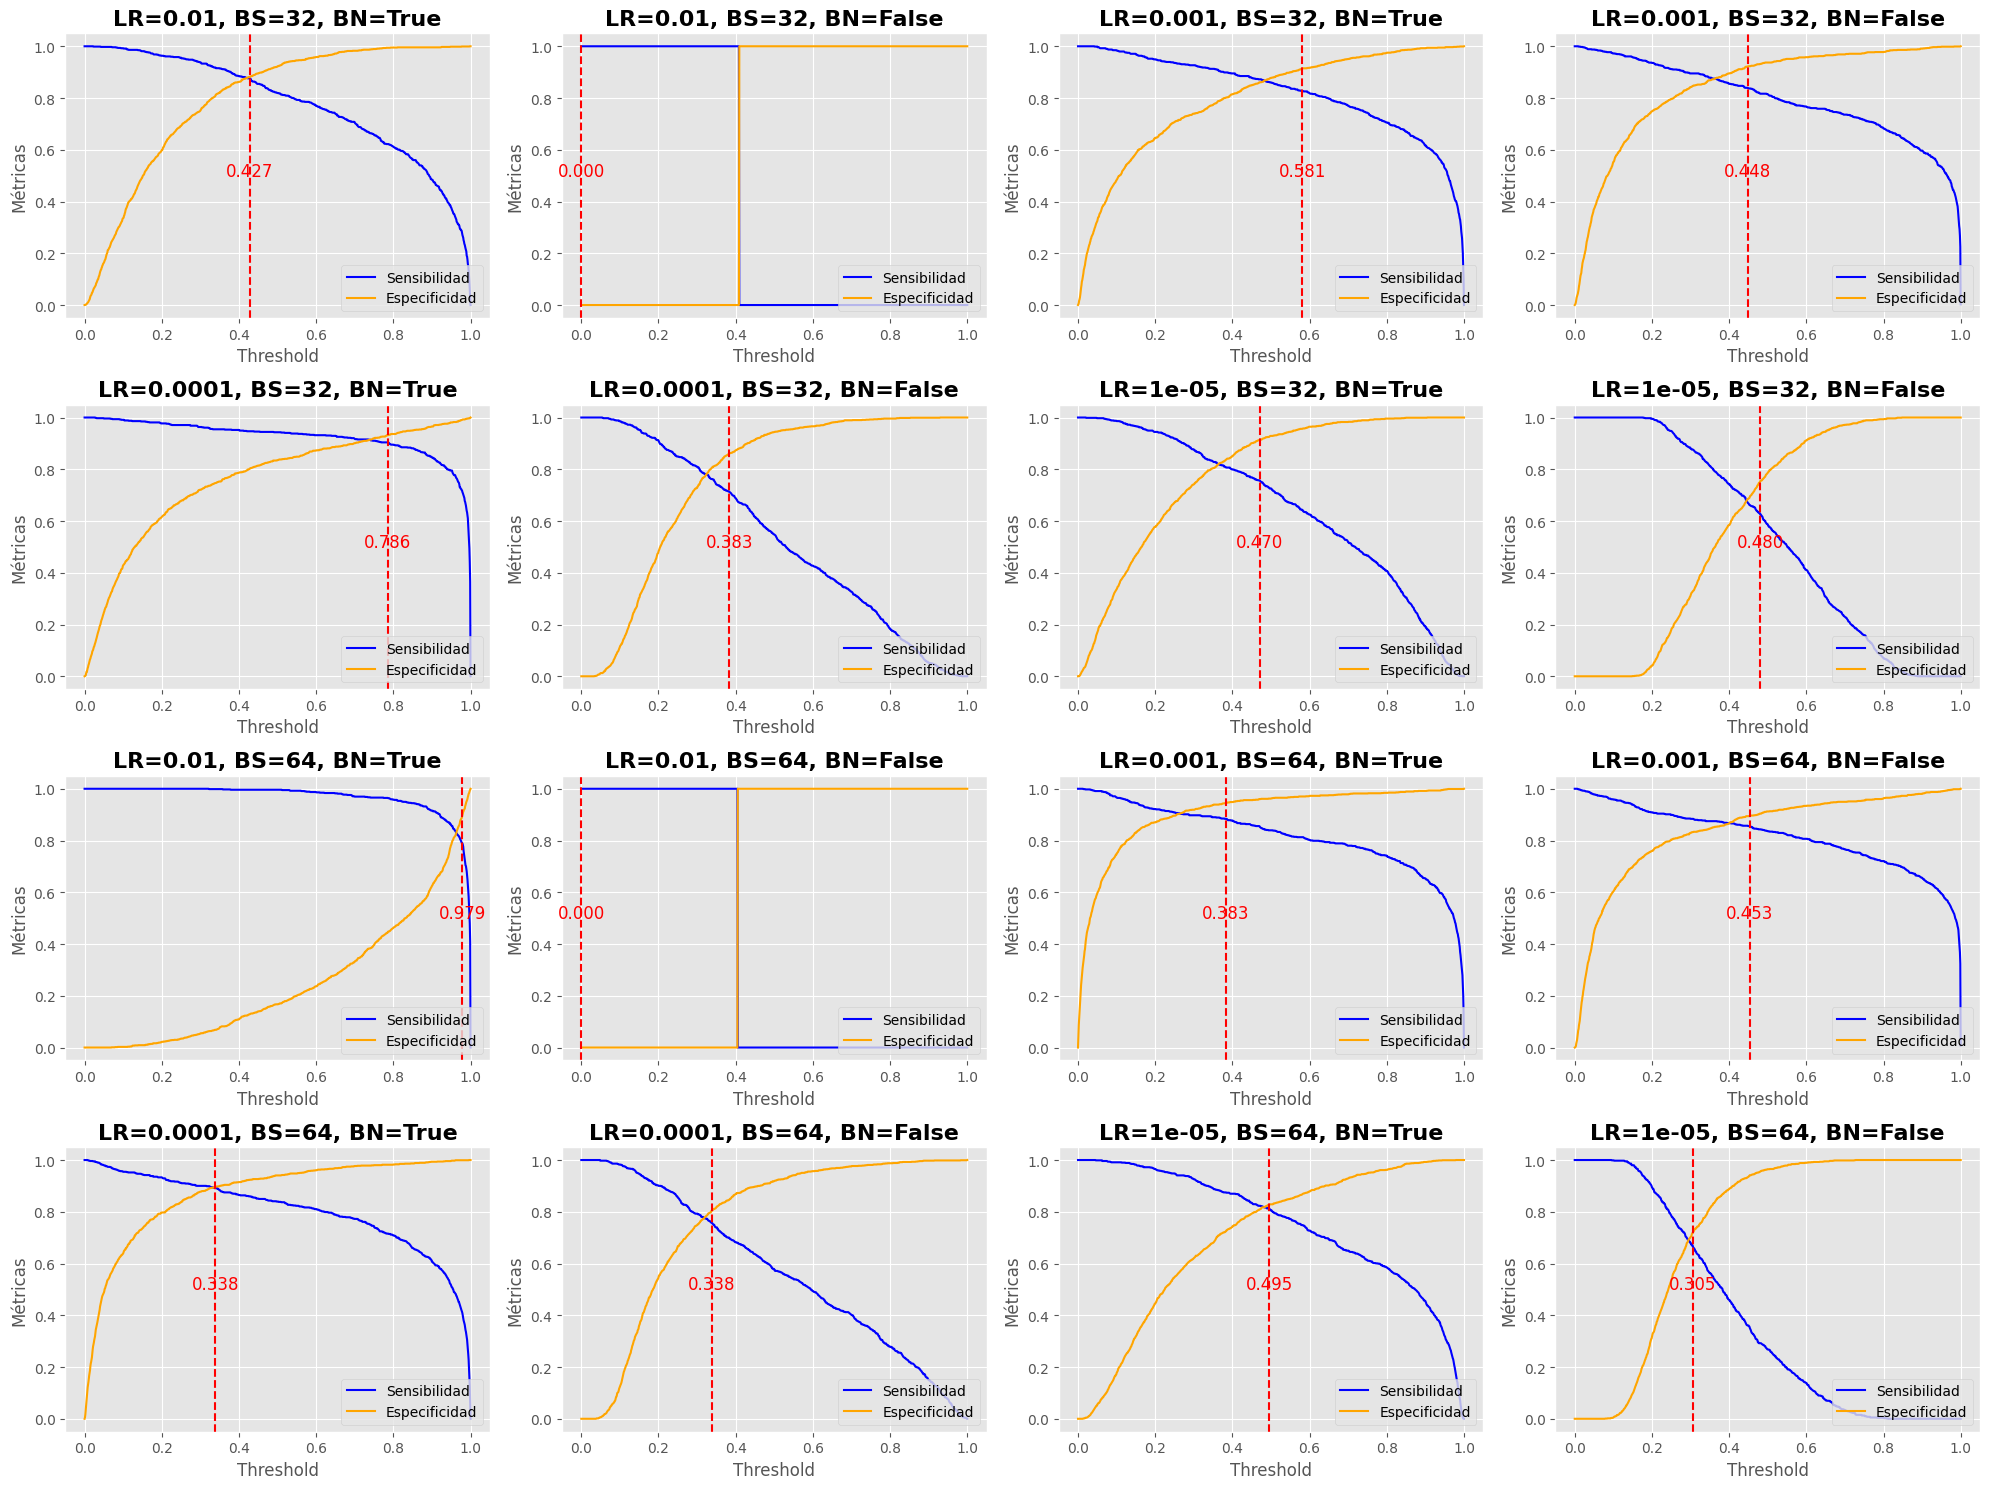

In [ ]:
n_models = len(models)
n_cols, n_rows = 4, 4
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 15))

for i, (y_true, y_score, model_info) in enumerate(zip(y_trues, y_scores, models)):
    row = i // n_cols
    col = i % n_cols
    best_sensitivity, best_specificity, best_threshold = calculate_metrics_at_best_threshold(y_true, y_score)
    plot_sens_spec(axes[row, col], y_true, y_score)
    axes[row, col].set_title(model_info[1], fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

---

Esta grafica muestra la sensibilidad y especificidad en función del umbral. Los mejores modelos en términos de umbral son aquellos que logran un balance entre alta sensibilidad y especificidad. El modelo con **LR=0.001, BS=64, BN=True** y **umbral alrededor de 0.38** parece ofrecer unas buenas metricas de sensibilidad y especificidad, ya que si subimos un poco el umbral de sensibilidad -> la especificidad no estaria muy perjudicada.

---

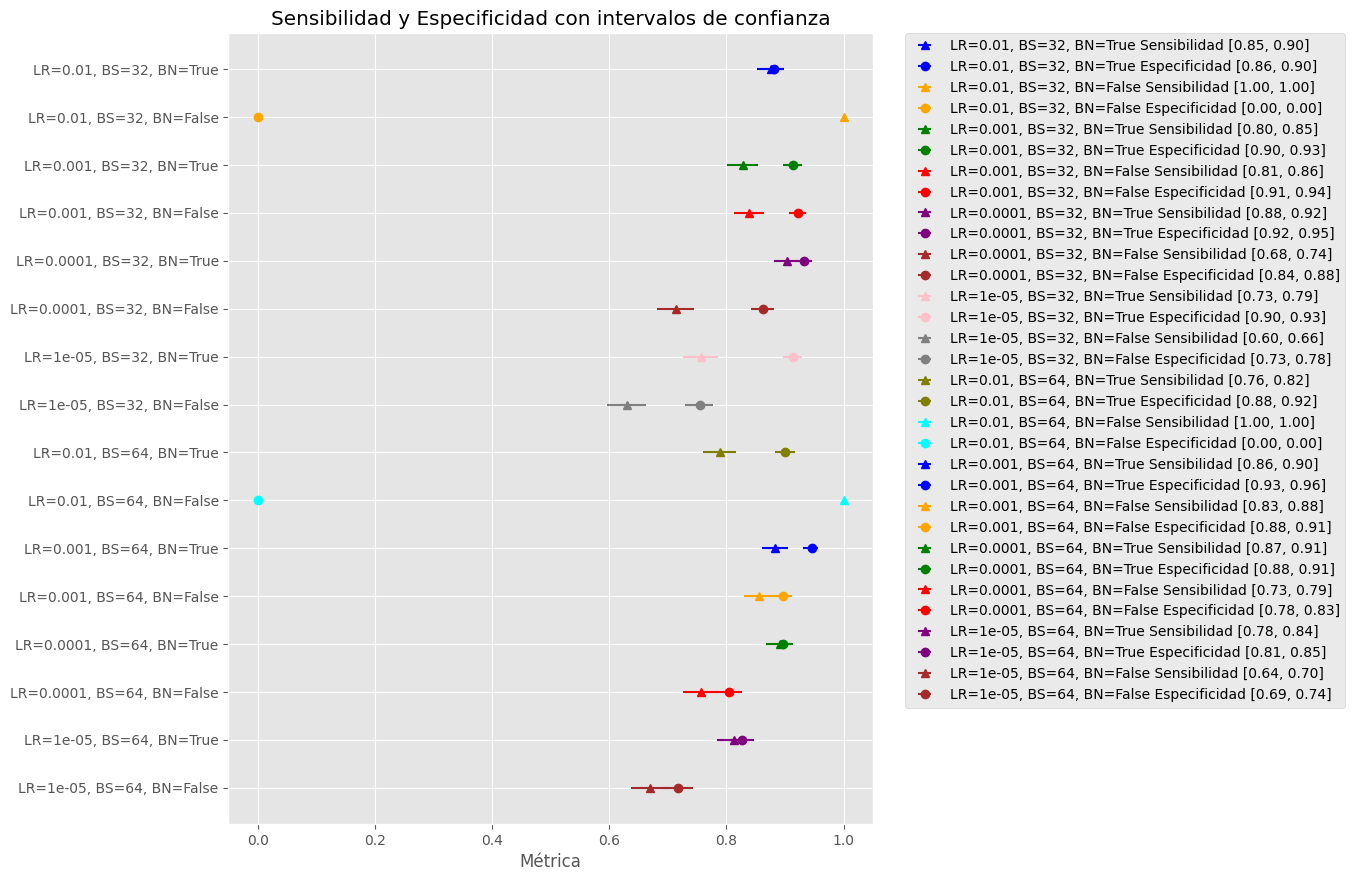

In [ ]:
plot_metrics_and_intervals(histories, y_trues, y_scores, models)

---

Esta grafica es de intervalos de confianza para la sensibilidad de cada modelo. Los modelos con **BN=True** muestran mejores resultados en los intervalos de confianza, lo que indica unas buenas metricas en sensibilidad.

Y en la grafica de los intervalos de confianza para la especificidad, los resultados son similares a la gráfica de sensibilidad, los modelos con **BN=True** presentan mayores intervalos de confianza. Sin embargo, los modelos con **BN=False** tienden a ser más consistentes en términos de especificidad.

---

## **5. Conclusion final**

Teniendo en cuenta que nuestro objetivo es detectar caras de menores de edad, **es muy importante maximizar la sensibilidad**. Los modelos con **BN=True, LR=0.001 / LR=0.0001 han mostrado tener alta sensibilidad** y una alta especificidad tambien. Especificamente, el modelo con **LR=0.0001, BS=32, BN=True presenta un buen resultado entre estas métricas, lo que lo hace ideal para nuestro caso de uso.**

Este modelo logra una sensibilidad alta con un umbral óptimo, lo que es fundamental para minimizar los falsos negativos y garantizar que se detecten la mayoría de los menores de edad.

En general todos los modelos que han tenido el BN = True han tenido mejores resultados.

(En V1 salia el modelo de LR=0.001, BS=64, BN=True)

## **Modelo final -> LR=0.0001, BS=32, BN=True**
